In [1]:
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

"""
Quais foram as compras de jogadores com melhores e 
piores custo-benefício registradas?
"""

def open_csv(arquivo):
    with open('../data/'+arquivo+'.csv', 'r', encoding='latin1') as file:
        return pd.read_csv(file)
    
#Tabelas a serem utilizadas

appearances = open_csv("appearances")
game_events = open_csv("game_events")
player_valuations = open_csv("player_valuations")
players = open_csv("players")
transfers = open_csv("transfers")

#Em transfers, ordenar pelo valor
#Proxy para determinar se o jogar é bom: appearances, game_events


In [8]:
def create_h2(path):
    #Criação do arquivo CSV, caso ainda não criado
    #if not os.path.exists(PATH):
        cost_benefit = pd.DataFrame({
            "player_id": [],
            "from_club_id": [],
            "to_club_id": [],
            "date": [],
            "cost_benefit": []
        })
        cost_benefit.to_csv(path, index=False)
        return

def create_h5(path):
    #Criação do arquivo CSV, caso ainda não criado
    #if not os.path.exists(PATH):
        cost_benefit = pd.DataFrame({
            "player_id": [],
            "mean_price": [],
            "performance": []
        })
        cost_benefit.to_csv(path, index=False)
        return

def add_h2(path, player_id, from_club_id, to_club_id, date, cb):
    #Inserção de cada transferência ao CSV
    cost_benefit = pd.DataFrame({
            "player_id": [player_id],
            "from_club_id": [from_club_id],
            "to_club_id": [to_club_id],
            "date": [date],
            "cost_benefit": [cb]             
    })
    cost_benefit.to_csv(path, mode='a', header=False, index=False)
    return

def add_h5(path, player_id, mean_price, performance):
    #Inserção de cada transferência ao CSV
    cost_benefit = pd.DataFrame({
            "player_id": [player_id],
            "mean_price": [mean_price],
            "performance": [performance]             
    })
    cost_benefit.to_csv(path, mode='a', header=False, index=False)
    return

def get_parameters(start_price, final_price, start_date, final_date, appearances_player):
    data_parameters = {
        "games_played": 0,
        "yellow_cards": 0,
        "red_cards": 0,
        "goals": 0,
        "assists": 0,
        "start_price": start_price,
        "final_price": final_price}
    
    for _, each_row_appearances_player in appearances_player.iterrows():
        game_date = parse_date(each_row_appearances_player["date"])
        if start_date <= game_date and game_date <= final_date:
            data_parameters["games_played"] += 1
            data_parameters["yellow_cards"] += each_row_appearances_player["yellow_cards"]
            data_parameters["red_cards"] += each_row_appearances_player["red_cards"]
            data_parameters["goals"] += each_row_appearances_player["goals"]
            data_parameters["assists"] += each_row_appearances_player["assists"]
    return data_parameters

def update_parameters(data_parameters_total, data_parameters):
    data_parameters_total["games_played"] += data_parameters["games_played"]
    data_parameters_total["yellow_cards"] += data_parameters["yellow_cards"]
    data_parameters_total["red_cards"] += data_parameters["red_cards"]
    data_parameters_total["goals"] += data_parameters["goals"]
    data_parameters_total["assists"] += data_parameters["assists"]
    return data_parameters_total

def proxy(games_played, yellow_cards, red_cards, goals, assists, start_price, final_price):
    delta_price = final_price - start_price
    modificador = 10 ** (len(str(delta_price))-1)

    #Fórmula para calcular desempenho do jogador, segundo sites esportivos (contem modificacao)
    reduce = ( (-1)*yellow_cards + (-3)*red_cards + (8)*goals + (5)*assists ) * modificador / games_played
    return round((reduce + delta_price) / start_price, 4)

def proxy2(games_played, yellow_cards, red_cards, goals, assists):
    reduce = ( (-1)*yellow_cards + (-3)*red_cards + (8)*goals + (5)*assists ) * 100 / games_played
    return round(reduce, 4)
    
def calc_mean_price(player_valuations):
    player_valuations.reset_index(drop=True, inplace=True)
    total_days = 0
    total_market_value = 0
    for index, each_row_player_valuations in player_valuations.iterrows():
        market_value = each_row_player_valuations['market_value_in_eur']
        start_date = parse_date(each_row_player_valuations['date'])
        if index < len(player_valuations) - 1:
            final_date = parse_date(player_valuations.loc[index+1,'date'])
        else:
            final_date = datetime.now().date()
        diferenca = final_date - start_date
        days = diferenca.days
        total_days += days
        total_market_value += market_value * days
    return round(total_market_value / total_days, 2)

def parse_date(date_str: str) -> date:
    if len(date_str) > 10:
        return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date()
    return datetime.strptime(date_str, '%Y-%m-%d').date()

#Tabelas a serem utilizadas
appearances.dropna(axis=0, inplace=True) 
game_events.dropna(axis=0, inplace=True)
player_valuations.dropna(axis=0, inplace=True)
players.dropna(axis=0, subset=["market_value_in_eur"], inplace=True)
transfers.dropna(axis=0, subset=["market_value_in_eur"], inplace=True)

In [9]:
create_h2('../data/cost_benefit2.csv')
create_h5('../data/performance.csv')

#Para cada jogador catalogado em "players"
for player_id in players['player_id']:
    transfers_player = transfers.loc[transfers['player_id'] == player_id]
    #Se esse jogador tiver transferências em "transfers"
    if not transfers_player.empty:
        transfers_player.sort_values(by='transfer_date', ascending=True, inplace=True)
        transfers_player.reset_index(drop=True, inplace=True)
        data_parameters_total = {
            "games_played": 0,
            "yellow_cards": 0,
            "red_cards": 0,
            "goals": 0,
            "assists": 0}
        mean_price = calc_mean_price(player_valuations.loc[player_valuations['player_id'] == player_id])
        #Para cada transferência referente a esse jogador
        for index, each_row_transfers_player in transfers_player.iterrows():
            start_date = parse_date(each_row_transfers_player['transfer_date'])
            from_club_id = each_row_transfers_player['from_club_id']
            to_club_id = each_row_transfers_player['to_club_id']
            start_price = each_row_transfers_player['market_value_in_eur']
            if index < len(transfers_player) - 1:
                final_date = parse_date(transfers_player.loc[index+1,'transfer_date'])
                final_price = transfers_player.loc[index+1,'market_value_in_eur']
            else:
                final_date = datetime.now().date()
                final_price = players.loc[players['player_id'] == player_id, 'market_value_in_eur'].values[0]
            
            #Para cada jogo entre as datas da transfência atual e a próxima
            appearances_player = appearances.loc[appearances['player_id'] == player_id]
            data_parameters = get_parameters(start_price, final_price, start_date, final_date, appearances_player)
            data_parameters_total = update_parameters(data_parameters_total, data_parameters)
            if data_parameters["games_played"] != 0:
                add_h2('../data/cost_benefit2.csv', player_id, from_club_id, to_club_id, start_date, proxy(**data_parameters))
        if data_parameters_total["games_played"] != 0:
            add_h5('../data/performance.csv', player_id, mean_price, proxy2(**data_parameters_total))


C:\Users\luizb\AppData\Local\Temp\ipykernel_12244\3188607555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_player.sort_values(by='transfer_date', ascending=True, inplace=True)


          player_id   from_club_id     to_club_id  cost_benefit
count  2.069500e+04   20695.000000   20695.000000  20695.000000
mean   3.384331e+05    6169.044793    4995.468181    164.324394
std    2.200875e+05   13125.388730   12701.960235   1319.714718
min    3.333000e+03       1.000000       2.000000  -1716.000000
25%    1.684395e+05     368.000000     336.000000      0.000000
50%    2.947670e+05    1038.000000     935.000000      4.807700
75%    4.692110e+05    5771.000000    2824.500000     70.981450
max    1.237998e+06  111702.000000  111271.000000  95801.040800


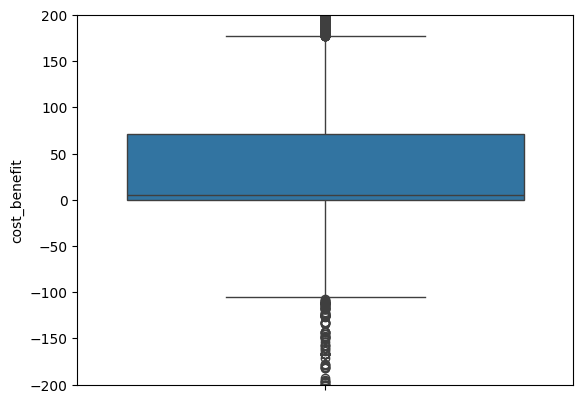

In [11]:
cost_benefit = open_csv("cost_benefit2")
cost_benefit.sort_values(by='cost_benefit', ascending=True, inplace=True)
print(cost_benefit.describe())
sns.boxplot(data=cost_benefit, y="cost_benefit")
plt.ylim(-200, 200)
plt.show()

          player_id    mean_price  performance  log_mean_price
count  7.868000e+03  7.868000e+03  7868.000000     7868.000000
mean   4.246785e+05  3.474192e+06    77.038272       13.948304
std    2.443448e+05  6.803525e+06   106.367103        1.483596
min    3.333000e+03  1.000000e+04  -300.000000        9.210340
25%    2.341920e+05  3.617160e+05     0.000000       12.798615
50%    3.952310e+05  9.645370e+05    42.487000       13.779403
75%    5.950712e+05  3.352592e+06   122.982325       15.025244
max    1.237998e+06  1.362647e+08   925.000000       18.730110


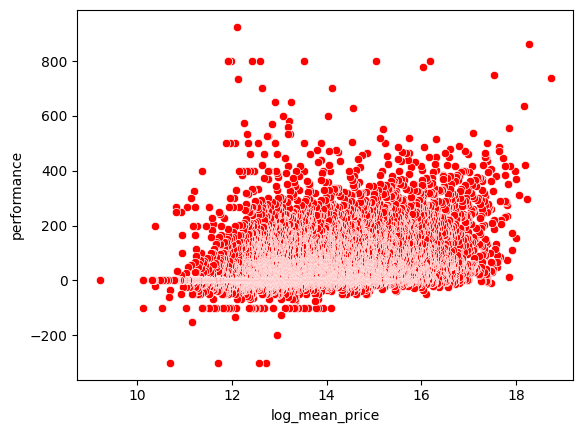

In [25]:
import numpy as np 
performance = open_csv("performance")
performance.sort_values(by='mean_price', ascending=False, inplace=True)

performance["log_mean_price"] = np.log(performance["mean_price"])

print(performance.describe())
sns.scatterplot(data=performance, x="log_mean_price", y="performance", color="red")
plt.show()

In [24]:
np.corrcoef(performance["performance"], performance["mean_price"])

array([[1.       , 0.3017927],
       [0.3017927, 1.       ]])

In [18]:

pd.merge(cost_benefit, players, how="left", on="player_id").sort_values("cost_benefit", ascending=False)


,player_id,from_club_id,to_club_id,date,cost_benefit,first_name,last_name,name,last_season,current_club_id,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
20694,342229,9669,162,2016-01-01,95801.0408,Kylian,MbappÃ©,Kylian MbappÃ©,2024,418,...,right,178.0,2029-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kylian-mbappe/...,ES1,Real Madrid Club de FÃºtbol,180000000.0,200000000.0
20693,533738,43562,157,2018-07-01,49204.2239,Jonathan,David,Jonathan David,2024,1082,...,both,180.0,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jonathan-david...,FR1,Lille Olympique Sporting Club Lille MÃ©tropole,50000000.0,60000000.0
20692,386726,10446,449,2015-12-21,48534.8621,Yusuf,YazÄ±cÄ±,Yusuf YazÄ±cÄ±,2023,1082,...,left,184.0,NaN,CY Management,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/yusuf-yazici/p...,FR1,Lille Olympique Sporting Club Lille MÃ©tropole,10000000.0,20000000.0
20691,485424,60309,3057,2017-07-01,47858.0476,Moussa,Djenepo,Moussa Djenepo,2024,589,...,right,177.0,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/moussa-djenepo...,TR1,Antalyaspor,3000000.0,13000000.0
20690,167850,4575,383,2012-01-01,43287.8496,Memphis,Depay,Memphis Depay,2023,13,...,right,178.0,NaN,TEAM DEPAY,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/memphis-depay/...,ES1,Club AtlÃ©tico de Madrid S.A.D.,10000000.0,55000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,355501,10155,1025,2015-07-01,-759.2143,Amadou,Diawara,Amadou Diawara,2024,58,...,right,183.0,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/amadou-diawara...,BE1,Royal Sporting Club Anderlecht,1500000.0,23000000.0
3,429901,22890,2865,2018-08-21,-861.0000,Paul,Akouokou,Paul Akouokou,2024,1041,...,right,181.0,2027-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/paul-akouokou/...,FR1,Olympique Lyonnais,1500000.0,5000000.0
2,417913,11610,472,2019-07-01,-1232.3514,Ãlvaro,Valles,Ãlvaro Valles,2024,472,...,right,191.0,2025-06-30 00:00:00,YOU FIRST,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/alvaro-valles/...,ES1,UniÃ³n Deportiva Las Palmas S.A.D.,12000000.0,15000000.0
1,177843,19114,6574,2012-07-01,-1254.3333,Domenico,Berardi,Domenico Berardi,2023,6574,...,left,183.0,2027-06-30 00:00:00,Simone Seghedoni,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/domenico-berar...,IT1,US Sassuolo,10000000.0,35000000.0


          player_id    mean_price  performance  log_mean_price
count  7.868000e+03  7.868000e+03  7868.000000     7868.000000
mean   4.246785e+05  3.474192e+06    77.038272       13.948304
std    2.443448e+05  6.803525e+06   106.367103        1.483596
min    3.333000e+03  1.000000e+04  -300.000000        9.210340
25%    2.341920e+05  3.617160e+05     0.000000       12.798615
50%    3.952310e+05  9.645370e+05    42.487000       13.779403
75%    5.950712e+05  3.352592e+06   122.982325       15.025244
max    1.237998e+06  1.362647e+08   925.000000       18.730110


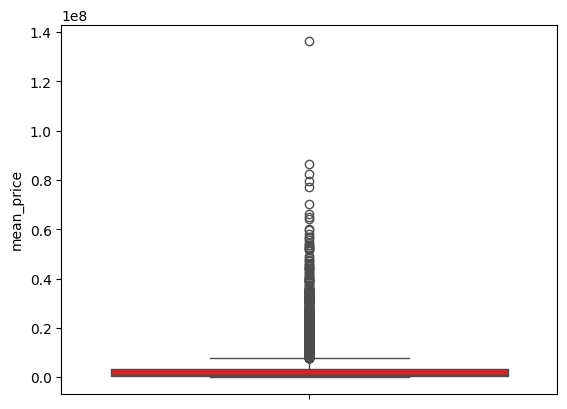

In [27]:
print(performance.describe())
sns.boxplot(data=performance, y="mean_price", color="red")
plt.show()

          player_id    mean_price  performance  log_mean_price
count  9.700000e+02  9.700000e+02   970.000000      970.000000
mean   3.401834e+05  1.744211e+07   144.842011       16.532612
std    2.110107e+05  1.146524e+07   130.662082        0.495554
min    3.333000e+03  7.841118e+06   -50.000000       15.874892
25%    1.814282e+05  1.005269e+07    42.288400       16.123350
50%    3.199430e+05  1.386228e+07   108.026200       16.444682
75%    4.722398e+05  2.052657e+07   227.956150       16.837228
max    1.082850e+06  1.362647e+08   862.814100       18.730110


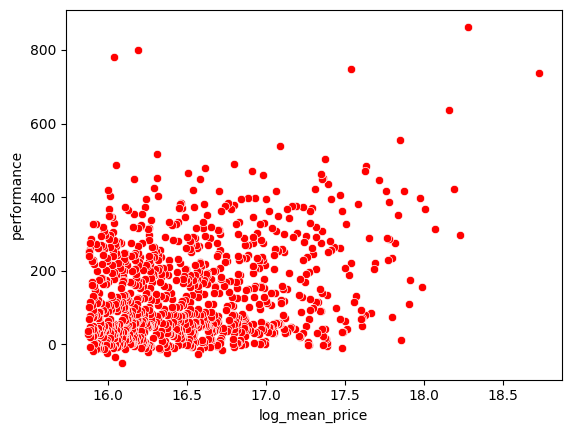

In [30]:
q1 = performance["mean_price"].quantile(0.25)
q3 = performance["mean_price"].quantile(0.75)

dq = q3 - q1

upper_limit = q3 + 1.5 * dq

performance_upper = performance[performance["mean_price"] >= upper_limit]
print(performance_upper.describe())
sns.scatterplot(data=performance_upper, x="log_mean_price", y="performance", color="red")
plt.show()

In [31]:
np.corrcoef(performance_upper["performance"], performance_upper["mean_price"])

array([[1.        , 0.31392041],
       [0.31392041, 1.        ]])

In [34]:
performance_teste = performance_upper[performance_upper["performance"] >= 600]
pd.merge(performance_teste, players, how="left", on="player_id").sort_values("performance", ascending=False)


,player_id,mean_price,performance,log_mean_price,first_name,last_name,name,last_season,current_club_id,player_code,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
1,418560,8.669576e+07,862.8141,18.277916,Erling,Haaland,Erling Haaland,2024,281,erling-haaland,...,left,195.0,2027-06-30 00:00:00,Rafaela Pimenta,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/erling-haaland...,GB1,Manchester City Football Club,180000000.0,180000000.0
4,382528,1.076971e+07,800.0000,16.192248,Kerem,AktÃ¼rkoÄlu,Kerem AktÃ¼rkoÄlu,2024,294,kerem-akturkoglu,...,right,173.0,2029-06-30 00:00:00,DW Sports Management,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kerem-akturkog...,PO1,Sport Lisboa e Benfica,15000000.0,17000000.0
5,325443,9.204331e+06,780.0000,16.035185,Viktor,GyÃ¶keres,Viktor GyÃ¶keres,2024,336,viktor-gyokeres,...,right,187.0,2028-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/viktor-gyokere...,PO1,Sporting Clube de Portugal,65000000.0,65000000.0
3,38253,4.150241e+07,749.2147,17.541262,Robert,Lewandowski,Robert Lewandowski,2024,131,robert-lewandowski,...,right,185.0,2026-06-30 00:00:00,Gol International,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/robert-lewando...,ES1,Futbol Club Barcelona,15000000.0,90000000.0
0,342229,1.362647e+08,738.4146,18.730110,Kylian,MbappÃ©,Kylian MbappÃ©,2024,418,kylian-mbappe,...,right,178.0,2029-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kylian-mbappe/...,ES1,Real Madrid Club de FÃºtbol,180000000.0,200000000.0
2,132098,7.721341e+07,637.3626,18.162084,Harry,Kane,Harry Kane,2024,27,harry-kane,...,right,188.0,2027-06-30 00:00:00,CK66,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/harry-kane/pro...,L1,FC Bayern MÃ¼nchen,100000000.0,150000000.0
